In [11]:
# Get the DF with PySpark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("YellowTripDataAnalysis").getOrCreate()

df = spark.read.option("header", True).option("inferSchema", True).csv("../data/yellow_tripdata/yellow_tripdata_2015-01.csv")

In [12]:
# Get the number of rows and columns in the DataFrame

num_rows = df.count()
num_cols = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 12748986
Number of columns: 19


In [13]:
# Get the characteristics of the DataFrame

df.describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+---------------------+------------------+
|summary|          VendorID|   passenger_count|     trip_distance|   pickup_longitude|   pickup_latitude|        RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|             mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+-------------------

In [14]:
# Print the first 20 rows of the DataFrame
df.show(20)

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|  -73.993896484375|  40.7501106262207|         1|    

In [15]:
# Set the main characteristics of the DataFrame to be used in the analysis and set the factor to clean each characteristic

charact_factor = {
    "passenger_count": 1e10,
    "trip_distance": 2.5,
    "payment_type": 3,
    "total_amount": 3,
    "tpep_pickup_datetime": 1e10,
    "tpep_dropoff_datetime": 1e10,
#    "pickup_longitude": 1e10,
#    "pickup_latitude": 1e10,
#    "dropoff_longitude": 1e10,
#    "dropoff_latitude": 1e10,
}

# Get sample data to make histogram

import pandas as pd

df_original_sample = df.select(list(charact_factor.keys())).sample(False, 0.05, seed=42).toPandas()

In [16]:
# Make a copy of the df_original_sample to df_sample
df_sample = df_original_sample.copy()

# Rows and columns of the DataFrame after cleaning
num_rows = df_original_sample.shape[0]
num_cols = df_original_sample.shape[1]
print(f"Number of rows after cleaning: {num_rows}")
print(f"Number of columns after cleaning: {num_cols}")

Number of rows after cleaning: 637214
Number of columns after cleaning: 6


In [17]:
df_sample.head(20)

,passenger_count,trip_distance,payment_type,total_amount,tpep_pickup_datetime,tpep_dropoff_datetime
0,5,2.83,2,14.30,2015-01-15 19:05:40,2015-01-15 19:21:00
1,1,3.00,2,12.80,2015-01-15 14:00:41,2015-01-15 14:13:48
2,2,1.18,1,13.40,2015-01-15 14:00:45,2015-01-15 14:16:31
3,1,3.50,1,18.95,2015-01-26 12:41:12,2015-01-26 12:59:47
4,1,1.00,1,8.76,2015-01-26 12:41:14,2015-01-26 12:48:18
5,1,1.90,2,13.30,2015-01-15 10:26:14,2015-01-15 10:42:16
6,1,0.30,2,6.80,2015-01-15 10:26:15,2015-01-15 10:33:37
7,1,2.70,1,13.55,2015-01-20 22:49:11,2015-01-20 22:58:29
8,1,5.70,1,30.96,2015-01-26 13:04:15,2015-01-26 13:40:37
9,1,0.60,1,7.55,2015-01-20 23:08:13,2015-01-20 23:12:51


In [18]:
# Clean the data
df_sample = df_sample.dropna()

# Create a new column with the trip duration in minutes
df_sample['trip_duration'] = (df_sample['tpep_dropoff_datetime'] - df_sample['tpep_pickup_datetime']).dt.total_seconds() / 60.0

# Add trip_duration to charact_factor to clean the data
charact_factor['trip_duration'] = 2

# Get only the hour of the day from tpep_pickup_datetime and tpep_dropoff_datetime columns in df_sample
df_sample['tpep_pickup_datetime'] = df_sample['tpep_pickup_datetime'].dt.hour
df_sample['tpep_dropoff_datetime'] = df_sample['tpep_dropoff_datetime'].dt.hour

# Delete the rows whete the trip_distance is negative or zero
df_sample = df_sample[df_sample['trip_distance'] > 0]

# Delete the rows where the total_amount is negative or zero
df_sample = df_sample[df_sample['total_amount'] > 0]

# Delete the rows where the passenger_count is negative or zero
df_sample = df_sample[df_sample['passenger_count'] > 0]

# Delete the rows where the trip_duration is negative or zero
df_sample = df_sample[df_sample['trip_duration'] > 0]

# Bind the trip_distance in very short, short, medium, long and very long trips with the following ranges:
# [1] short: 0.0 - 3.0
# [2] medium: 3.0 - 10.0
# [3] long: 10.0 - 100.0
df_sample['trip_distance_bind'] = pd.cut(df_sample['trip_distance'], bins=[0.0, 3.0, 10.0, 100.0], labels=[1, 2, 3])

# Bind the trip_duration in very short, short, medium, long and very long trips with the following ranges:
# [1] short: 0.0 - 10.0
# [2] medium: 10.0 - 20.0
# [3] long: 20.0 - 30.0
df_sample['trip_duration_bind'] = pd.cut(df_sample['trip_duration'], bins=[0.0, 10.0, 20.0, 100.0], labels=[1, 2, 3])

# Bind the total_amount in very_cheap, cheap, medium, expensive and very expensive trips with the following ranges:
# [1] cheap: 0.0 - 10.0
# [2] medium: 10.0 - 20.0
# [3] expensive: 20.0 - 100.0
df_sample['total_amount_bind'] = pd.cut(df_sample['total_amount'], bins=[0.0, 10.0, 20.0, 100], labels=[1, 2, 3])

# Bind the passender_count in few and many passengers with the following ranges:
# [1] few: 0.0 - 2.0
# [2] many: 2.0 - 6.0
df_sample['passenger_count_bind'] = pd.cut(df_sample['passenger_count'], bins=[0.0, 2.0, 6.0], labels=[1, 2])

# Bind the payment_type in credit card and others with the following ranges:
# [1] credit card: 1.0
# [2] others: 2.0 - 6.0
df_sample['payment_type_bind'] = pd.cut(df_sample['payment_type'], bins=[0.0, 1.0, 6.0], labels=[1, 2])

# Clean the data again to remove the rows with NaN values after the binning
df_sample = df_sample.dropna()

# Convert to int trip_distance_bind
df_sample['trip_distance_bind'] = df_sample['trip_distance_bind'].astype(int)

# Convert to int trip_duration_bind
df_sample['trip_duration_bind'] = df_sample['trip_duration_bind'].astype(int)

# Convert to int total_amount_bind
df_sample['total_amount_bind'] = df_sample['total_amount_bind'].astype(int)

# Convert to int passenger_count_bind
df_sample['passenger_count_bind'] = df_sample['passenger_count_bind'].astype(int)

# Convert to int payment_type_bind
df_sample['payment_type_bind'] = df_sample['payment_type_bind'].astype(int)

# Delete the outliers
for col, factor in charact_factor.items():
    q1 = df_sample[col].quantile(0.25)
    q3 = df_sample[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    df_sample = df_sample[(df_sample[col] >= lower_bound) & (df_sample[col] <= upper_bound)]

In [19]:
# Characteristics of the DataFrame after cleaning
df_sample.describe()

,passenger_count,trip_distance,payment_type,total_amount,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration,trip_distance_bind,trip_duration_bind,total_amount_bind,passenger_count_bind,payment_type_bind
count,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000,579656.000000
mean,1.682108,1.987711,1.389526,11.893999,13.616893,13.609662,10.509575,1.184577,1.539315,1.632496,1.152226,1.386201
std,1.338269,1.463512,0.495658,5.333008,6.401048,6.462102,6.028403,0.387954,0.646185,0.642442,0.359241,0.486878
min,1.000000,0.010000,1.000000,0.300000,0.000000,0.000000,0.016667,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,0.960000,1.000000,7.850000,9.000000,9.000000,5.866667,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.530000,1.000000,10.560000,14.000000,14.000000,9.300000,1.000000,1.000000,2.000000,1.000000,1.000000
75%,2.000000,2.560000,2.000000,14.600000,19.000000,19.000000,14.016667,1.000000,2.000000,2.000000,1.000000,2.000000
max,6.000000,8.000000,4.000000,35.180000,23.000000,23.000000,30.900000,2.000000,3.000000,3.000000,2.000000,2.000000


In [20]:
# Rows and columns of the DataFrame after cleaning
num_rows = df_sample.shape[0]
num_cols = df_sample.shape[1]
print(f"Number of rows after cleaning: {num_rows}")
print(f"Number of columns after cleaning: {num_cols}")

Number of rows after cleaning: 579656
Number of columns after cleaning: 12


In [21]:
# Print the first 20 rows of the cleaned DataFrame
df_sample.head(20)

,passenger_count,trip_distance,payment_type,total_amount,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration,trip_distance_bind,trip_duration_bind,total_amount_bind,passenger_count_bind,payment_type_bind
0,5,2.83,2,14.30,19,19,15.333333,1,2,2,2,2
1,1,3.00,2,12.80,14,14,13.116667,1,2,2,1,2
2,2,1.18,1,13.40,14,14,15.766667,1,2,2,1,1
3,1,3.50,1,18.95,12,12,18.583333,2,2,2,1,1
4,1,1.00,1,8.76,12,12,7.066667,1,1,1,1,1
5,1,1.90,2,13.30,10,10,16.033333,1,2,2,1,2
6,1,0.30,2,6.80,10,10,7.366667,1,1,1,1,2
7,1,2.70,1,13.55,22,22,9.300000,1,1,2,1,1
9,1,0.60,1,7.55,23,23,4.633333,1,1,1,1,1
10,1,3.80,1,24.73,23,23,13.450000,2,2,3,1,1


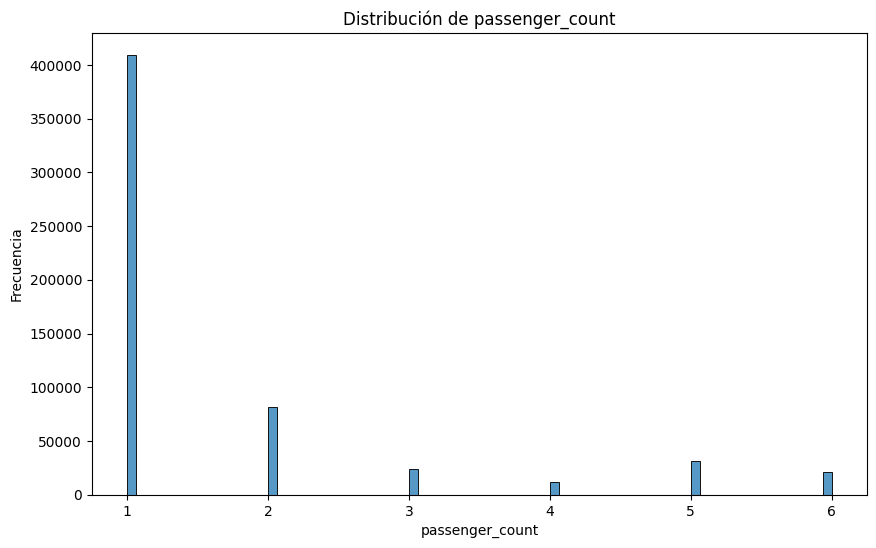

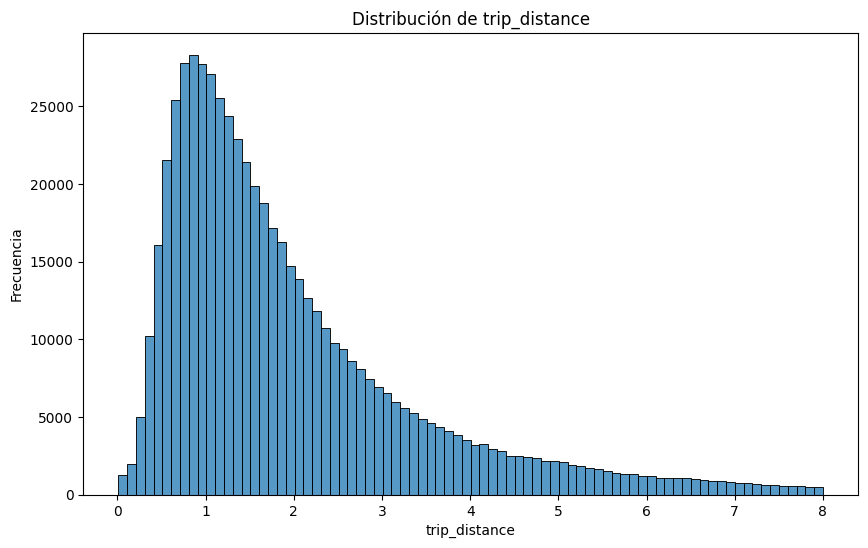

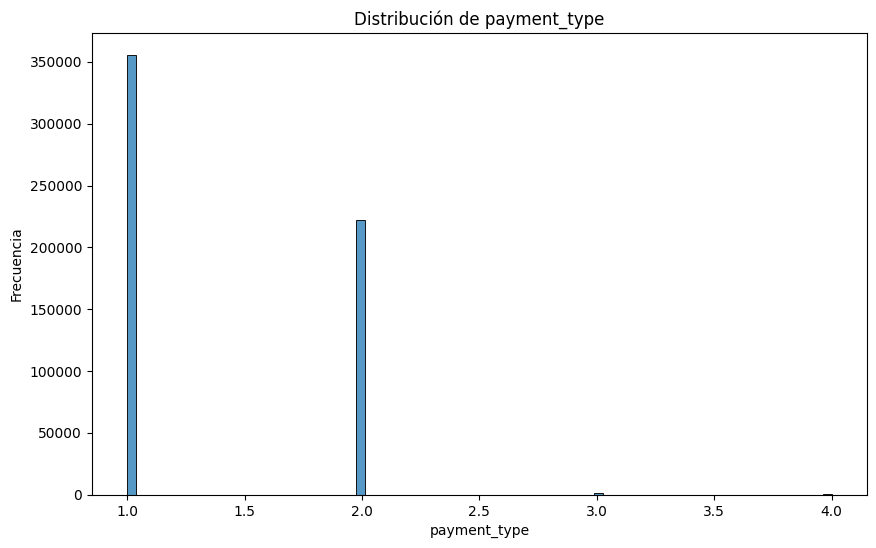

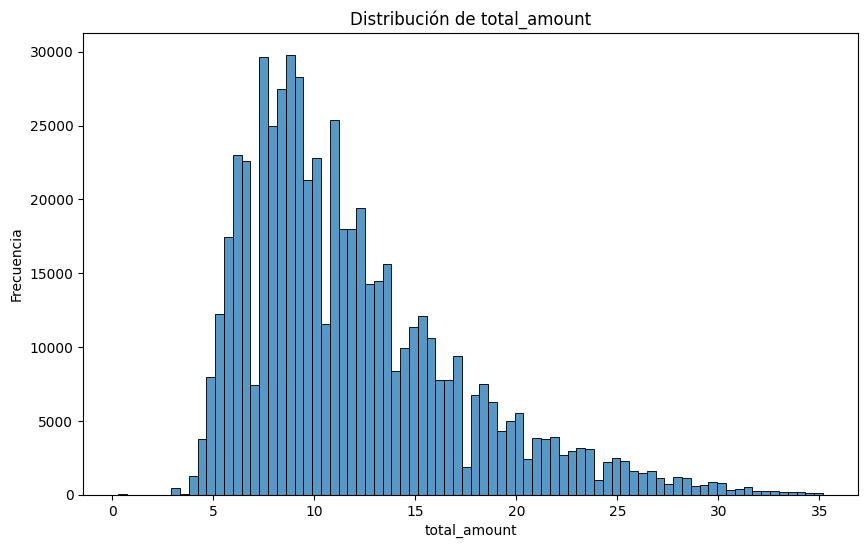

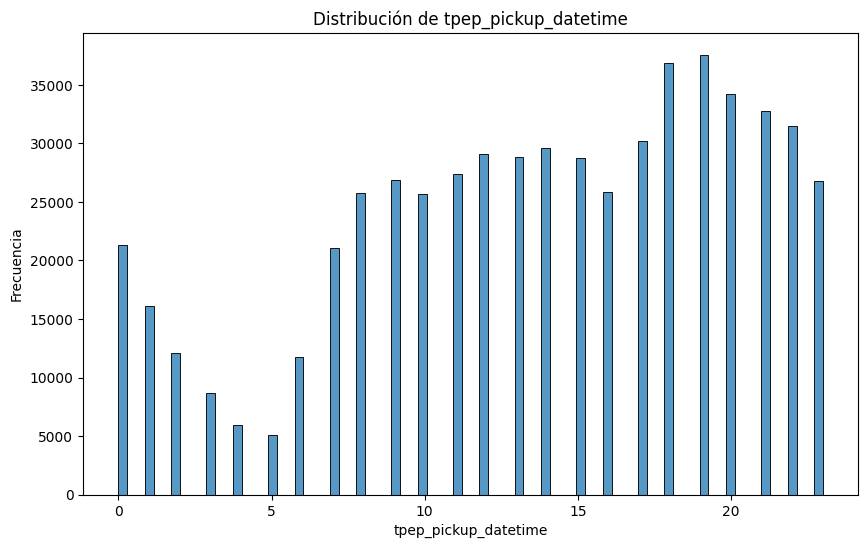

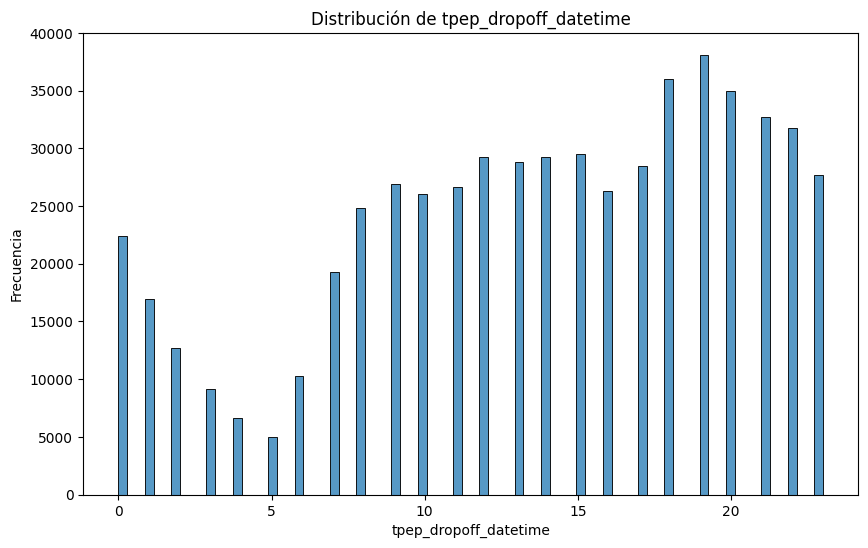

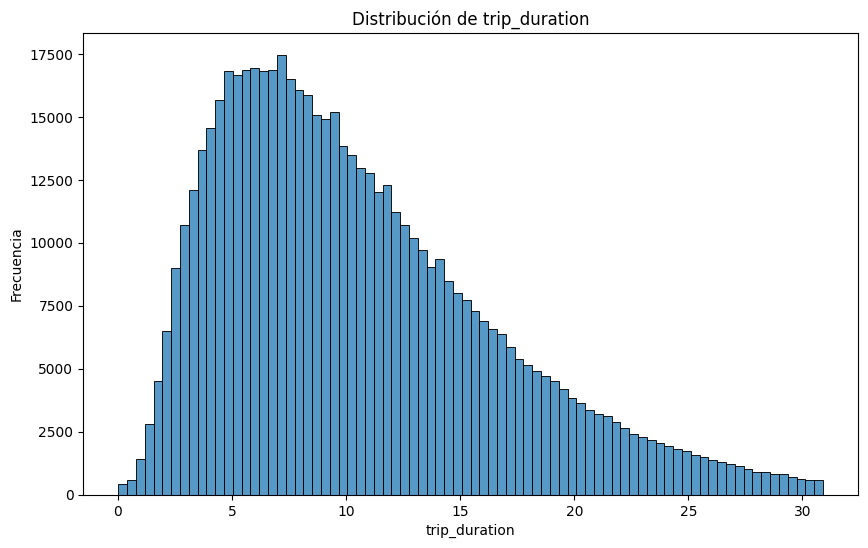

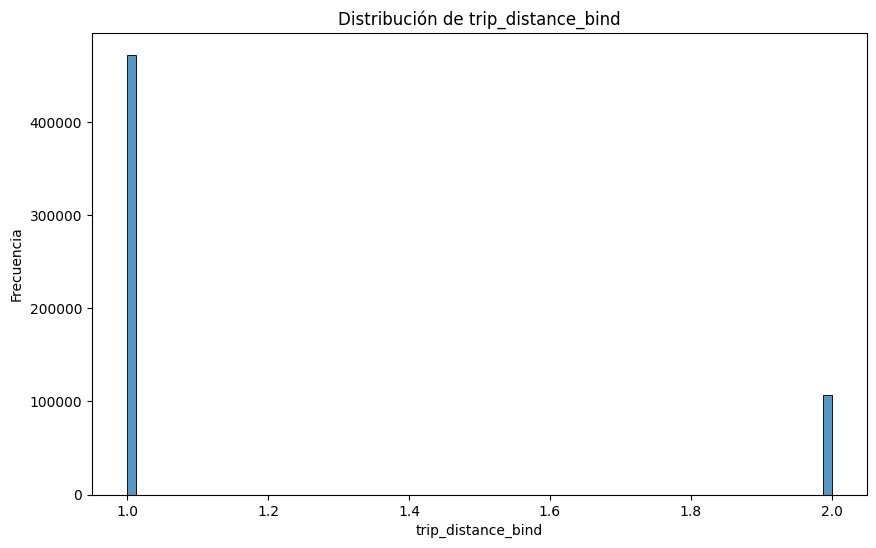

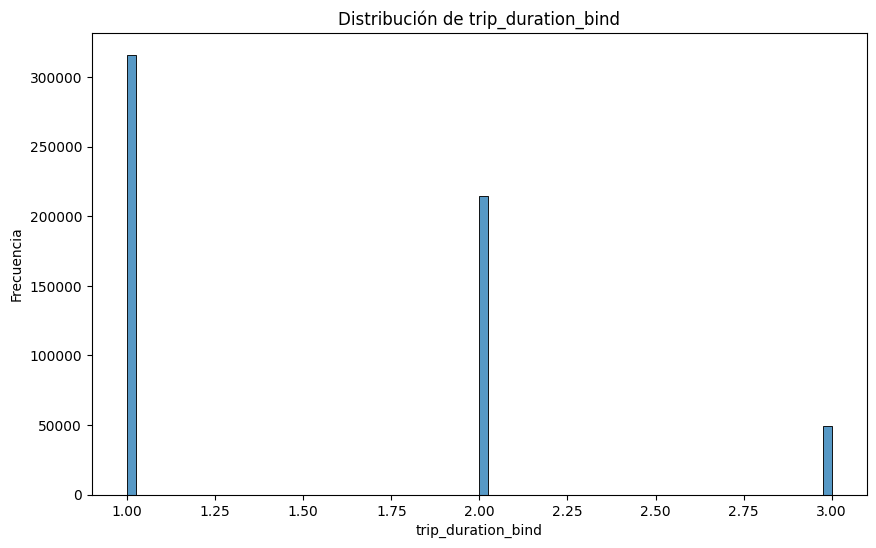

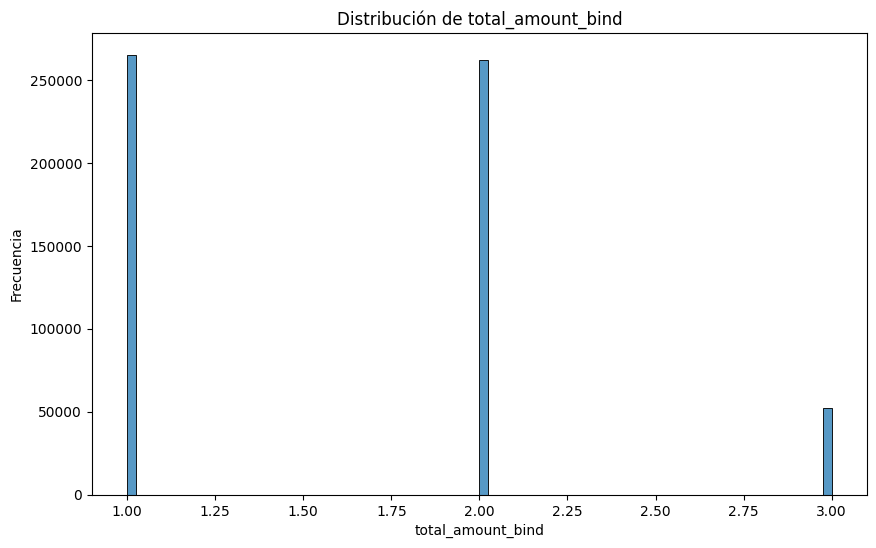

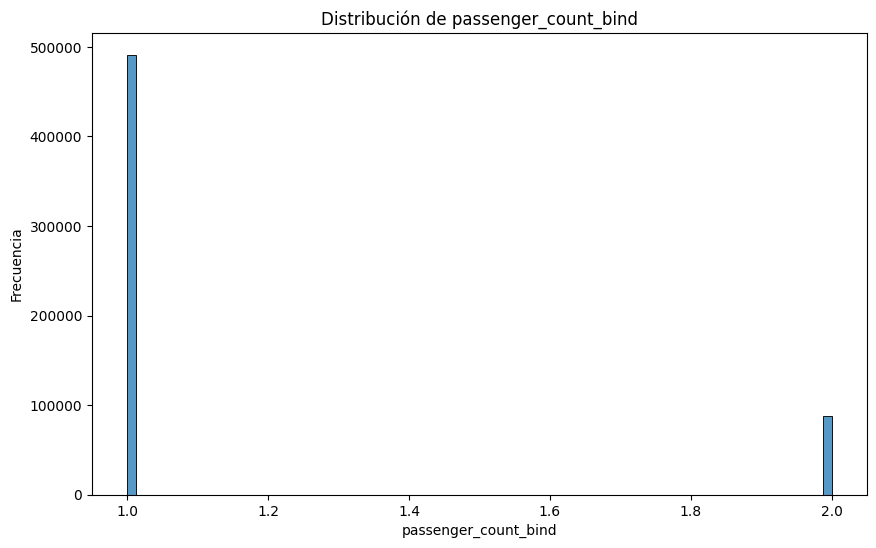

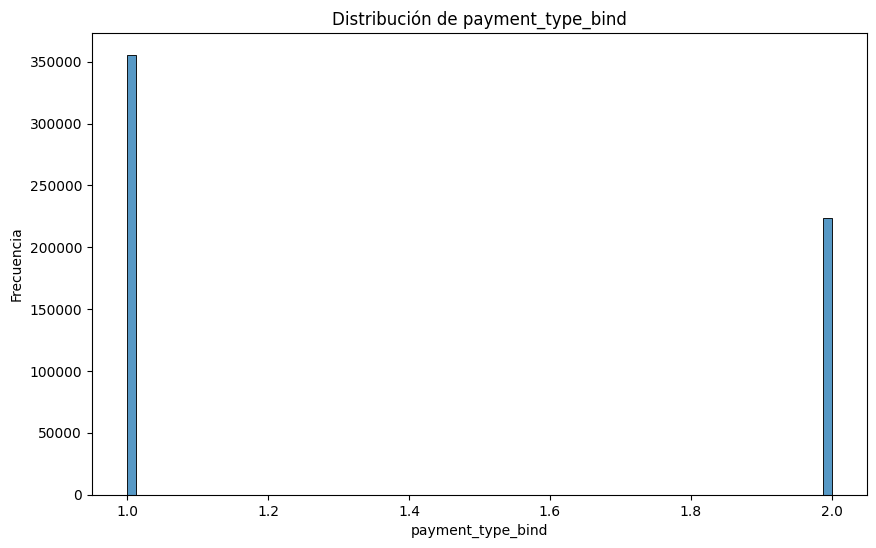

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot(df_sample["passenger_count"], bins=80)
# plt.title("Distribución de cantidad de pasajeros")
# plt.xlabel("Cantidad de pasajeros")
# plt.ylabel("Frecuencia")
# plt.show()
# 
# sns.histplot(df_sample["trip_distance"], bins=80)
# plt.title("Distribución de distancias de viaje")
# plt.xlabel("Distancia (millas)")
# plt.ylabel("Frecuencia")
# plt.show()
# 
# sns.histplot(df_sample["payment_type"], bins=80)
# plt.title("Distribución de tipos de pago")
# plt.xlabel("Tipo de pago")
# plt.ylabel("Frecuencia")
# plt.show()
# 
# sns.histplot(df_sample["total_amount"], bins=80)
# plt.title("Distribución de total del viaje")
# plt.xlabel("Total del viaje ($)")
# plt.ylabel("Frecuencia")
# plt.show()

for col in df_sample.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_sample[col], bins=80)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

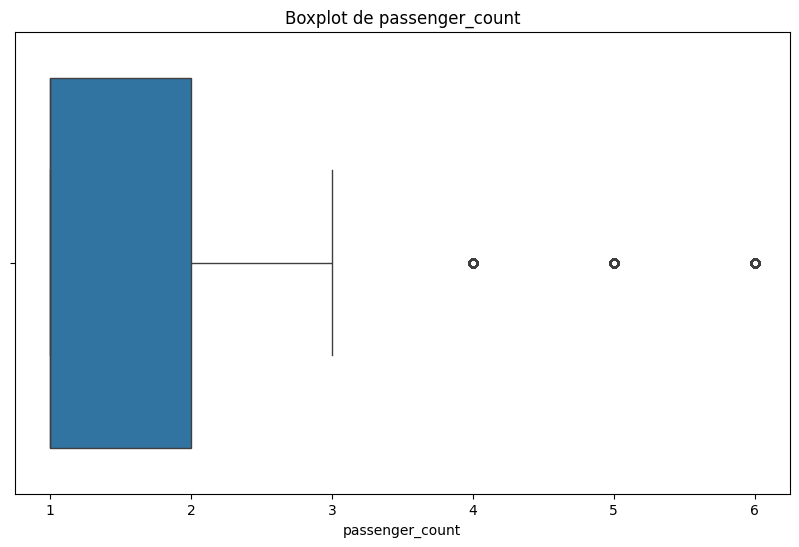

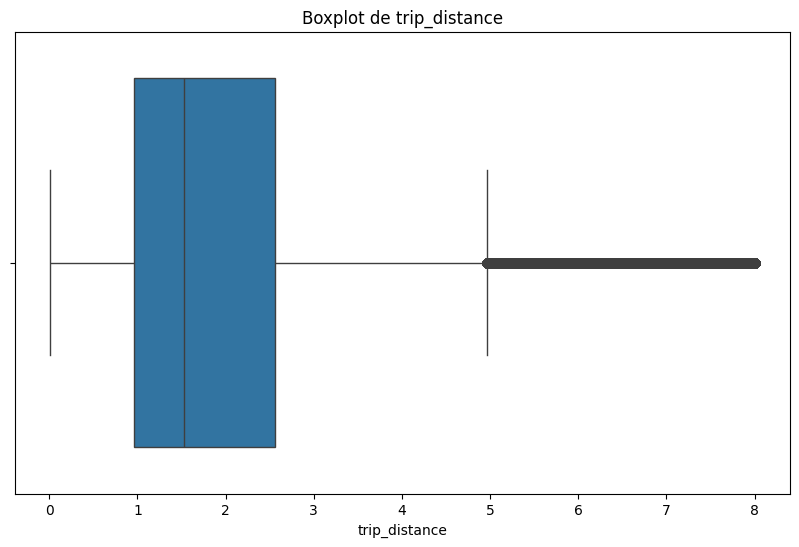

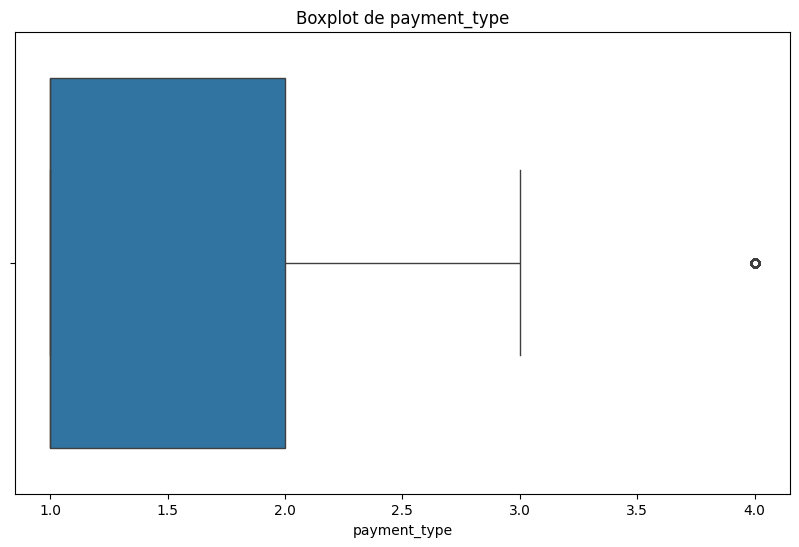

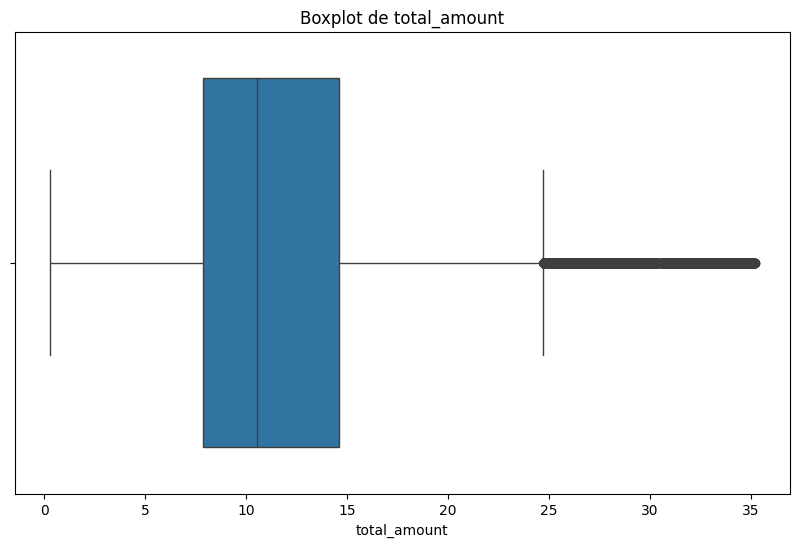

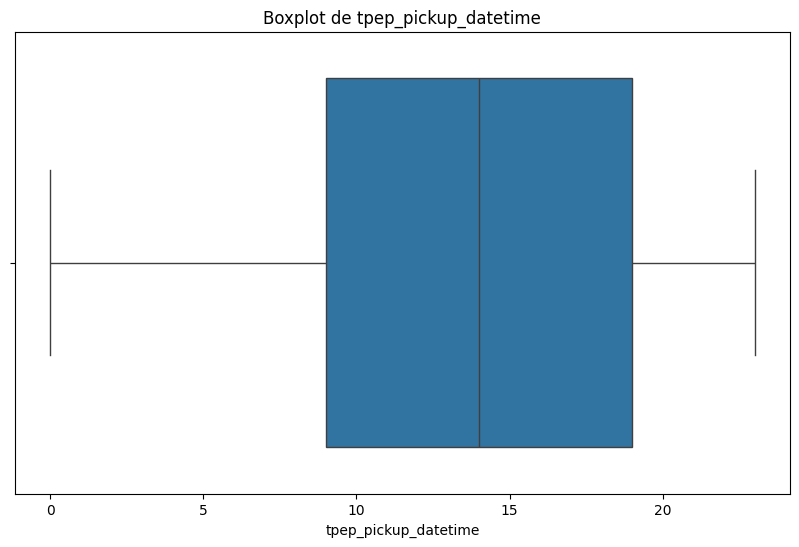

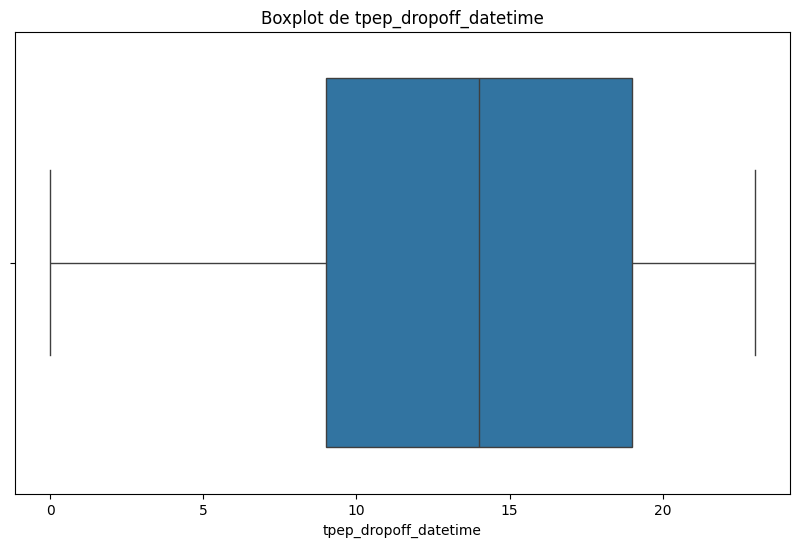

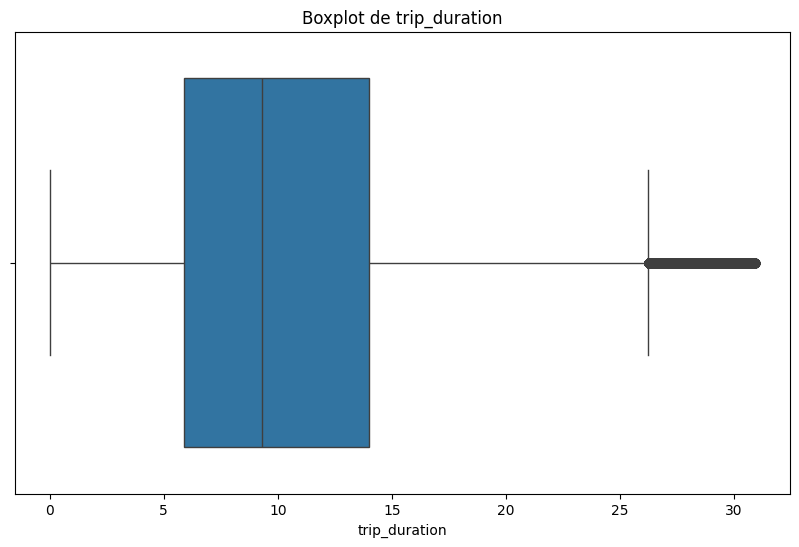

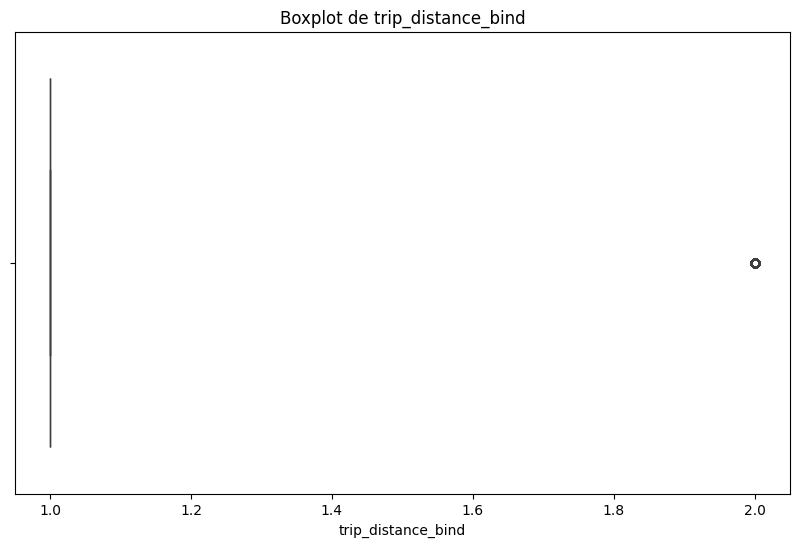

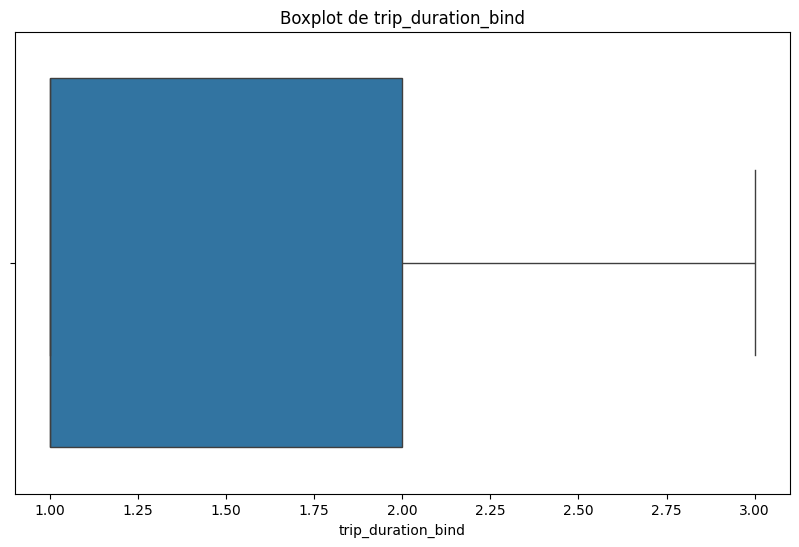

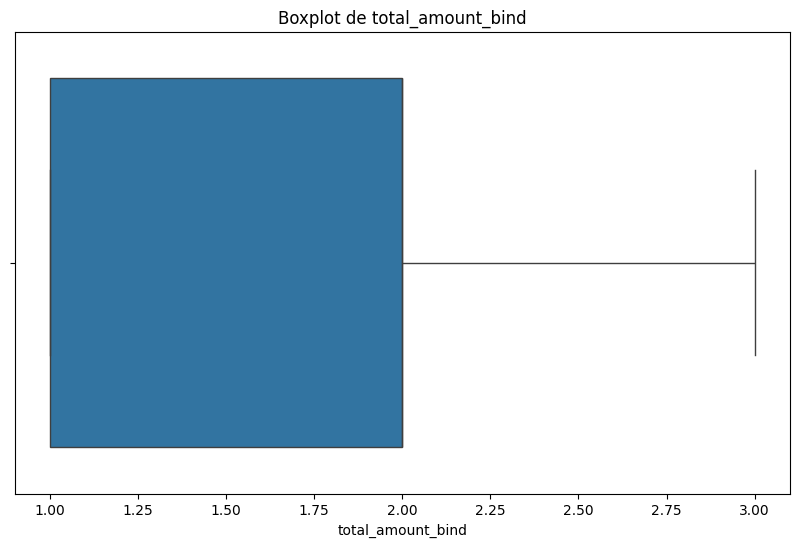

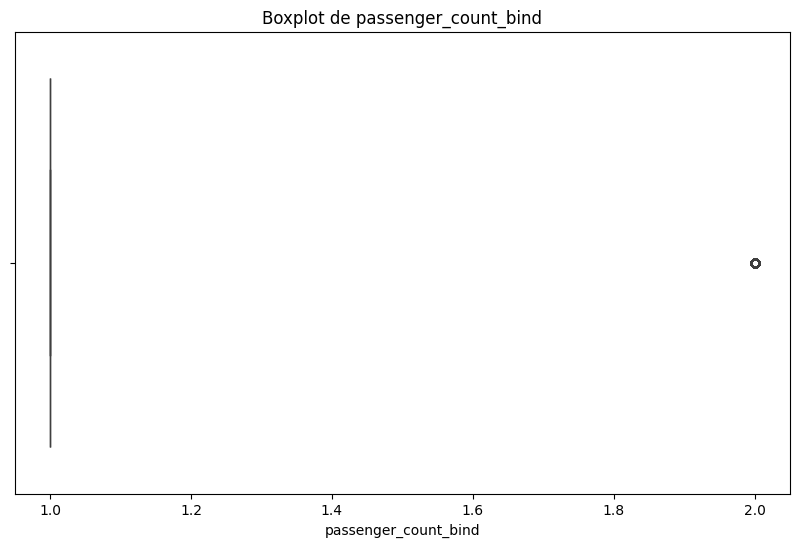

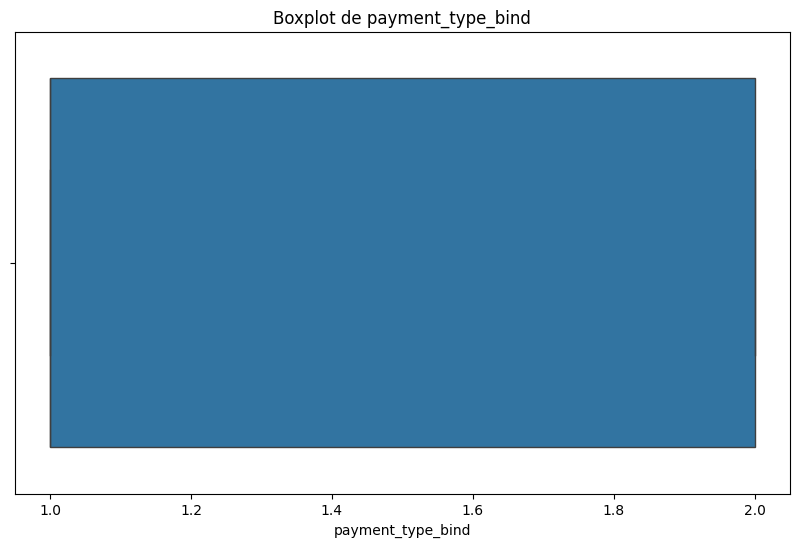

In [23]:
# Boxplot of the cleaned DataFrame
for col in df_sample.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_sample[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

<Axes: >

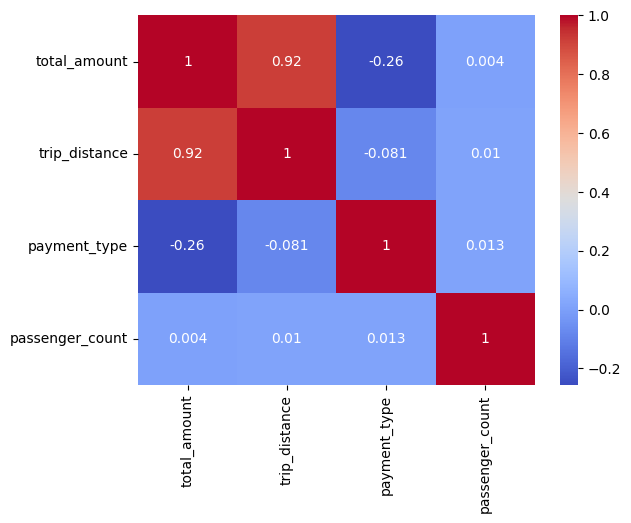

In [24]:
# Make a copy of the df_sample to df_sample_corr
df_sample_corr = df_sample.copy()

# Columnas para coorrelacionar
columns = [
    "total_amount",
    "trip_distance",
    "payment_type",
    "passenger_count",
]

# Remove the columns that ends in _bind
df_sample_corr = df_sample_corr[columns]

# Calculate the correlation matrix
corr = df_sample_corr.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [25]:
# Índice de iteraciones
from itertools import product


iterations = {
    "total_amount_bind": [1, 2, 3],
    "trip_distance_bind": [1, 2, 3],
    "payment_type_bind": [1, 2],
    "passenger_count_bind": [1, 2],
#    "tpep_pickup_datetime": [9, 19],
#    "tpep_dropoff_datetime": [9, 19],
#    "trip_duration": [1, 2, 3],
}

# Número total de filas
total_rows = len(df_sample)

# Extracción de nombres de las columnas y las listas de valores
keys = list(iterations.keys())
values = list(iterations.values())

# Crear todas las combinaciones posibles de los valores
combinations = list(product(*values))

# Número de iteración
iter_num = 1

# Suma total de proporciones
total_proportion = 0

# Iterar sobre combinaciones
for comb in combinations:
    filtered_rows = df_sample[
        (df_sample[keys[0]] == comb[0]) &
        (df_sample[keys[1]] == comb[1]) &
        (df_sample[keys[2]] == comb[2]) &
        (df_sample[keys[3]] == comb[3])
     #   (df_sample[keys[4]] == comb[4])
    #    (df_sample[keys[5]] == comb[5])
    #    (df_sample[keys[6]] == comb[6])
    ]
    # Proporción
    proportion = len(filtered_rows) / total_rows
    print(f"Combinación: {comb} / iteración: {iter_num}, Proporción: {proportion:.4f}")
    iter_num += 1
    total_proportion += proportion
    
# Print total proportion
print(f"Proporción total: {total_proportion:.4f}")


Combinación: (1, 1, 1, 1) / iteración: 1, Proporción: 0.1931
Combinación: (1, 1, 1, 2) / iteración: 2, Proporción: 0.0327
Combinación: (1, 1, 2, 1) / iteración: 3, Proporción: 0.1955
Combinación: (1, 1, 2, 2) / iteración: 4, Proporción: 0.0362
Combinación: (1, 2, 1, 1) / iteración: 5, Proporción: 0.0000
Combinación: (1, 2, 1, 2) / iteración: 6, Proporción: 0.0000
Combinación: (1, 2, 2, 1) / iteración: 7, Proporción: 0.0001
Combinación: (1, 2, 2, 2) / iteración: 8, Proporción: 0.0000
Combinación: (1, 3, 1, 1) / iteración: 9, Proporción: 0.0000
Combinación: (1, 3, 1, 2) / iteración: 10, Proporción: 0.0000
Combinación: (1, 3, 2, 1) / iteración: 11, Proporción: 0.0000
Combinación: (1, 3, 2, 2) / iteración: 12, Proporción: 0.0000
Combinación: (2, 1, 1, 1) / iteración: 13, Proporción: 0.2218
Combinación: (2, 1, 1, 2) / iteración: 14, Proporción: 0.0384
Combinación: (2, 1, 2, 1) / iteración: 15, Proporción: 0.0778
Combinación: (2, 1, 2, 2) / iteración: 16, Proporción: 0.0154
Combinación: (2, 

### 1. Tabla de variables de caracterización

| Variable | Dominio | Estadísticas típicas | Comentarios
|-|-|-|-|
| total_amount | cheap [1] - normal [2] - expensive [3] | 1 - 2 - 3 | Se eliminan outliers y determinan las estadísticas típicas |
| trip_distance | short [1] - normal [2] - long [3] | 1 - 2 - 3 | Valores típicos, sesgo derecho dominante. |
| payment_type | credit card [1] - cash and others [2] | 1 - 2 | Se paga con tarjeta de crédito casi un 50% más que el resto. |
| passenger_count | only one [1] - two or more [2] | 1 - 2 | Domina el viaje de 1 persona, sin embargo de dos o más también es un importante número.|

### 2. Reglas de particionamiento

| Combinación | Regla aplicada | Proporcion en D |
|-|-|-|
| data | total_amount == 1 AND trip_distance == 1 && payment_type == 1 AND passenger_count == 1 | **0.1931**
| data | total_amount == 1 AND trip_distance == 1 && payment_type == 1 AND passenger_count == 2 | 0.0327
| data | total_amount == 1 AND trip_distance == 1 && payment_type == 2 AND passenger_count == 1 | **0.1955**
| data | total_amount == 1 AND trip_distance == 1 && payment_type == 2 AND passenger_count == 2 | 0.0362
| data | total_amount == 1 AND trip_distance == 2 && payment_type == 1 AND passenger_count == 1 | 0.0000
| data | total_amount == 1 AND trip_distance == 2 && payment_type == 1 AND passenger_count == 2 | 0.0000
| data | total_amount == 1 AND trip_distance == 2 && payment_type == 2 AND passenger_count == 1 | 0.0001
| data | total_amount == 1 AND trip_distance == 2 && payment_type == 2 AND passenger_count == 2 | 0.0000
| data | total_amount == 1 AND trip_distance == 3 && payment_type == 1 AND passenger_count == 1 | 0.0000
| data | total_amount == 1 AND trip_distance == 3 && payment_type == 1 AND passenger_count == 2 | 0.0000
| data | total_amount == 1 AND trip_distance == 3 && payment_type == 2 AND passenger_count == 1 | 0.0000
| data | total_amount == 1 AND trip_distance == 3 && payment_type == 2 AND passenger_count == 2 | 0.0000
| data | total_amount == 2 AND trip_distance == 1 && payment_type == 1 AND passenger_count == 1 | **0.2218**
| data | total_amount == 2 AND trip_distance == 1 && payment_type == 1 AND passenger_count == 2 | 0.0384
| data | total_amount == 2 AND trip_distance == 1 && payment_type == 2 AND passenger_count == 1 | **0.0778**
| data | total_amount == 2 AND trip_distance == 1 && payment_type == 2 AND passenger_count == 2 | 0.0154
| data | total_amount == 2 AND trip_distance == 2 && payment_type == 1 AND passenger_count == 1 | 0.0463
| data | total_amount == 2 AND trip_distance == 2 && payment_type == 1 AND passenger_count == 2 | 0.0084
| data | total_amount == 2 AND trip_distance == 2 && payment_type == 2 AND passenger_count == 1 | 0.0366
| data | total_amount == 2 AND trip_distance == 2 && payment_type == 2 AND passenger_count == 2 | 0.0074
| data | total_amount == 2 AND trip_distance == 3 && payment_type == 1 AND passenger_count == 1 | 0.0000
| data | total_amount == 2 AND trip_distance == 3 && payment_type == 1 AND passenger_count == 2 | 0.0000
| data | total_amount == 2 AND trip_distance == 3 && payment_type == 2 AND passenger_count == 1 | 0.0000
| data | total_amount == 2 AND trip_distance == 3 && payment_type == 2 AND passenger_count == 2 | 0.0000
| data | total_amount == 3 AND trip_distance == 1 && payment_type == 1 AND passenger_count == 1 | 0.0038
| data | total_amount == 3 AND trip_distance == 1 && payment_type == 1 AND passenger_count == 2 | 0.0006
| data | total_amount == 3 AND trip_distance == 1 && payment_type == 2 AND passenger_count == 1 | 0.0001
| data | total_amount == 3 AND trip_distance == 1 && payment_type == 2 AND passenger_count == 2 | 0.0000
| data | total_amount == 3 AND trip_distance == 2 && payment_type == 1 AND passenger_count == 1 | **0.0585**
| data | total_amount == 3 AND trip_distance == 2 && payment_type == 1 AND passenger_count == 2 | 0.0101
| data | total_amount == 3 AND trip_distance == 2 && payment_type == 2 AND passenger_count == 1 | 0.0141
| data | total_amount == 3 AND trip_distance == 2 && payment_type == 2 AND passenger_count == 2 | 0.0029
| data | total_amount == 3 AND trip_distance == 3 && payment_type == 1 AND passenger_count == 1 | 0.0000
| data | total_amount == 3 AND trip_distance == 3 && payment_type == 1 AND passenger_count == 2 | 0.0000
| data | total_amount == 3 AND trip_distance == 3 && payment_type == 2 AND passenger_count == 1 | 0.0000
| data | total_amount == 3 AND trip_distance == 3 && payment_type == 2 AND passenger_count == 2 | 0.0000

In [26]:
total_amount_bind = [0.0, 10.0, 20.0, 100.0]
trip_distance_bind = [0.0, 3.0, 10.0, 100.0]
payment_type_bind = [0.0, 1.0, 6.0]
passenger_count_bind = [0.0, 2.0, 6.0]

total_amount_bind_ranges = []
trip_distance_bind_ranges = []
payment_type_bind_ranges = []
passenger_count_bind_ranges = []

for i in range(len(total_amount_bind) - 1):
    total_amount_bind_ranges.append((total_amount_bind[i], total_amount_bind[i + 1]))
    
for i in range(len(trip_distance_bind) - 1):
    trip_distance_bind_ranges.append((trip_distance_bind[i], trip_distance_bind[i + 1]))
    
for i in range(len(payment_type_bind) - 1):
    payment_type_bind_ranges.append((payment_type_bind[i], payment_type_bind[i + 1]))
    
for i in range(len(passenger_count_bind) - 1):
    passenger_count_bind_ranges.append((passenger_count_bind[i], passenger_count_bind[i + 1]))

print("Total amount bind ranges: ", total_amount_bind_ranges)
print("Trip distance bind ranges: ", trip_distance_bind_ranges)
print("Payment type bind ranges: ", payment_type_bind_ranges)
print("Passenger count bind ranges: ", passenger_count_bind_ranges)

combinations = list(product(total_amount_bind_ranges, trip_distance_bind_ranges, payment_type_bind_ranges, passenger_count_bind_ranges))

print("Combinations: ", combinations)



Total amount bind ranges:  [(0.0, 10.0), (10.0, 20.0), (20.0, 100.0)]
Trip distance bind ranges:  [(0.0, 3.0), (3.0, 10.0), (10.0, 100.0)]
Payment type bind ranges:  [(0.0, 1.0), (1.0, 6.0)]
Passenger count bind ranges:  [(0.0, 2.0), (2.0, 6.0)]
Combinations:  [((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)), ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)), ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)), ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)), ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)), ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)), ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)), ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)), ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)), ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)), ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)), ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)), ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)), ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)), ((10.0

In [27]:
from pyspark.sql.functions import col

# Número total de filas
total_rows = df.count()

subsets = []
iter_num = 1
total_proportion = 0

for comb in combinations:
    filtered_rows = df.filter(
        (col("total_amount") > comb[0][0]) & (col("total_amount") <= comb[0][1]) &
        (col("trip_distance") > comb[1][0]) & (col("trip_distance") <= comb[1][1]) &
        (col("payment_type") > comb[2][0]) & (col("payment_type") <= comb[2][1]) &
        (col("passenger_count") > comb[3][0]) & (col("passenger_count") <= comb[3][1])
    )
    subsets.append(filtered_rows)
    # Proporción
    prop = filtered_rows.count() / total_rows
    total_proportion += prop
    print(f"Porcentaje: {total_proportion:.2f} / combinación: {comb} / iteración: {iter_num} / proporción: {prop:.4f}")
    iter_num += 1
    
# Print total proportion
print(f"Proporción total: {total_proportion:.4f}")

Porcentaje: 0.18 / combinación: ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 1 / proporción: 0.1753


Porcentaje: 0.21 / combinación: ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 2 / proporción: 0.0298


Porcentaje: 0.38 / combinación: ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 3 / proporción: 0.1786


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 4 / proporción: 0.0330


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 5 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 6 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 7 / proporción: 0.0002


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 8 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 9 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 10 / proporción: 0.0000


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 11 / proporción: 0.0001


Porcentaje: 0.42 / combinación: ((0.0, 10.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 12 / proporción: 0.0000


Porcentaje: 0.62 / combinación: ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 13 / proporción: 0.2025


Porcentaje: 0.65 / combinación: ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 14 / proporción: 0.0346


Porcentaje: 0.72 / combinación: ((10.0, 20.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 15 / proporción: 0.0707


Porcentaje: 0.74 / combinación: ((10.0, 20.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 16 / proporción: 0.0139


Porcentaje: 0.78 / combinación: ((10.0, 20.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 17 / proporción: 0.0425


Porcentaje: 0.79 / combinación: ((10.0, 20.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 18 / proporción: 0.0078


Porcentaje: 0.82 / combinación: ((10.0, 20.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 19 / proporción: 0.0333


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 20 / proporción: 0.0068


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 21 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 22 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 23 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((10.0, 20.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 24 / proporción: 0.0000


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 25 / proporción: 0.0044


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 26 / proporción: 0.0007


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 27 / proporción: 0.0006


Porcentaje: 0.83 / combinación: ((20.0, 100.0), (0.0, 3.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 28 / proporción: 0.0001


Porcentaje: 0.91 / combinación: ((20.0, 100.0), (3.0, 10.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 29 / proporción: 0.0740


Porcentaje: 0.92 / combinación: ((20.0, 100.0), (3.0, 10.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 30 / proporción: 0.0129


Porcentaje: 0.94 / combinación: ((20.0, 100.0), (3.0, 10.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 31 / proporción: 0.0209


Porcentaje: 0.95 / combinación: ((20.0, 100.0), (3.0, 10.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 32 / proporción: 0.0042


Porcentaje: 0.97 / combinación: ((20.0, 100.0), (10.0, 100.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 33 / proporción: 0.0259


Porcentaje: 0.98 / combinación: ((20.0, 100.0), (10.0, 100.0), (0.0, 1.0), (2.0, 6.0)) / iteración: 34 / proporción: 0.0046


Porcentaje: 0.99 / combinación: ((20.0, 100.0), (10.0, 100.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 35 / proporción: 0.0121


Porcentaje: 0.99 / combinación: ((20.0, 100.0), (10.0, 100.0), (1.0, 6.0), (2.0, 6.0)) / iteración: 36 / proporción: 0.0026
Proporción total: 0.9922


In [28]:
iter = 1

for subset in subsets:
    print(f"Subset [{iter}]: {subset.count()} rows")
    iter += 1

Subset [1]: 2234293 rows


Subset [2]: 380313 rows


Subset [3]: 2277397 rows


Subset [4]: 421030 rows


Subset [5]: 388 rows


Subset [6]: 29 rows


Subset [7]: 2305 rows


Subset [8]: 121 rows


Subset [9]: 90 rows


Subset [10]: 3 rows


Subset [11]: 1355 rows


Subset [12]: 81 rows


Subset [13]: 2581069 rows


Subset [14]: 441461 rows


Subset [15]: 901607 rows


Subset [16]: 177076 rows


Subset [17]: 541389 rows


Subset [18]: 98958 rows


Subset [19]: 424747 rows


Subset [20]: 86491 rows


Subset [21]: 121 rows


Subset [22]: 10 rows


Subset [23]: 223 rows


Subset [24]: 22 rows


Subset [25]: 56393 rows


Subset [26]: 8572 rows


Subset [27]: 7376 rows


Subset [28]: 1332 rows


Subset [29]: 944057 rows


Subset [30]: 164612 rows


Subset [31]: 266383 rows


Subset [32]: 54015 rows


Subset [33]: 330574 rows


Subset [34]: 58534 rows


Subset [35]: 154497 rows


Subset [36]: 32905 rows
